# **Set up**

Installing packages and downloading the MedNist dataset.

In [2]:
# Install MONAI (https://monai.io/)
!pip install -q "monai[pillow, tqdm]"
!pip install -q torch torchvision matplotlib sklearn

# Mount at my drive
from google.colab import drive
drive.mount('/content/drive')


     |████████████████████████████████| 358kB 15.3MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
Mounted at /content/drive


In [3]:
# Downloading the data
import tarfile
!wget -q https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz

datafile = tarfile.open("MedNIST.tar.gz")
datafile.extractall()
datafile.close()

print(datafile)

In [4]:
# Importing packages
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets, transforms

from monai.config import print_config
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.networks.nets import densenet121
from monai.metrics import compute_roc_auc

np.random.seed(0)

## Reading images from dataset folders and visualization

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


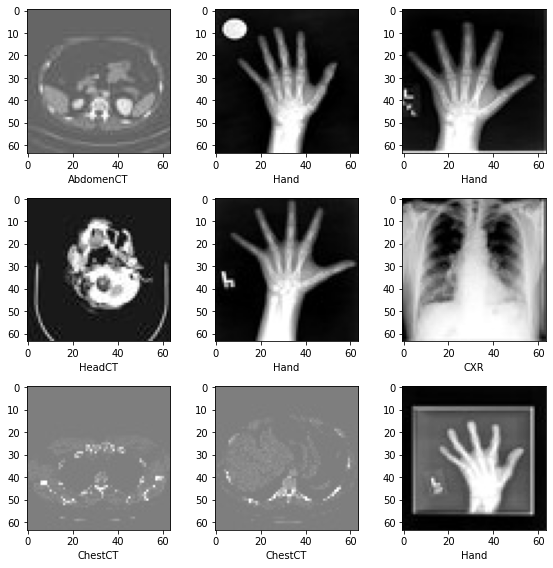

In [5]:
# Loading images
data_dir = './MedNIST/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

# Visualization
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Dataset pre-processing 


In [6]:
# Split training/validation and test set
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))



Training count = 41249 Validation count = 5913 Test count = 11792


In [14]:
# Transformations
train_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [13]:
# Creating datasets and dataloaders
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

# Model


## Hyperparameters and other variables

In [15]:
batch_size = 300
USE_CUDA = True
epoch_num = 5
val_interval = 1
adv_train = True

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (USE_CUDA and torch.cuda.is_available()) else "cpu")
#model = models.resnet50(pretrained=False, progress=True).to(device)
#model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)
model = densenet121(spatial_dims=2,in_channels=1, out_channels=num_class).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

CUDA Available:  True


# Adversarial set up

In [16]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [17]:
# Generating adversarial examples
def adv_examples_gen(model, data, target, epsilon):
    adv_count = 0
    if adv_train:
        scores = model(data)
        loss = F.cross_entropy(scores, target)
        optimizer.zero_grad()
        loss.backward()
        if random.uniform(0, 1) <= 0.5:
            adv_count += 1
            data_grad = data.grad.data
            # Call FGSM Attack, using epsilon 0.2
            data = fgsm_attack(data, 0.2, data_grad)
    return adv_count, data

## Training

In [19]:
# Normal Training

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

for epoch in range(epoch_num):
    adv_count = 0
    model = model.to(device)
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for (inputs, labels) in train_loader:
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True
        optimizer.zero_grad()

        adv_count, inputs = adv_examples_gen(model, inputs, labels, 0.2)

        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)

            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                with torch.no_grad():
                    torch.jit.save(torch.jit.trace(model, (inputs), check_trace=False), '/content/drive/MyDrive/Individual_project/MedNist_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
                
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/5
1/137, train_loss: 1.8240
2/137, train_loss: 1.8495
3/137, train_loss: 1.8251
4/137, train_loss: 1.7904
5/137, train_loss: 1.7909
6/137, train_loss: 1.7873
7/137, train_loss: 1.7138
8/137, train_loss: 1.7493
9/137, train_loss: 1.6710
10/137, train_loss: 1.7225
11/137, train_loss: 1.7145
12/137, train_loss: 1.6036
13/137, train_loss: 1.5873
14/137, train_loss: 1.5560
15/137, train_loss: 1.5366
16/137, train_loss: 1.5263
17/137, train_loss: 1.4929
18/137, train_loss: 1.6459
19/137, train_loss: 1.6390
20/137, train_loss: 1.4603
21/137, train_loss: 1.6398
22/137, train_loss: 1.4110
23/137, train_loss: 1.5906
24/137, train_loss: 1.5804
25/137, train_loss: 1.5724
26/137, train_loss: 1.3543
27/137, train_loss: 1.5752
28/137, train_loss: 1.3135
29/137, train_loss: 1.2785
30/137, train_loss: 1.5176
31/137, train_loss: 1.2925
32/137, train_loss: 1.2708
33/137, train_loss: 1.2651
34/137, train_loss: 1.2089
35/137, train_loss: 1.5209
36/137, train_loss: 1.5159
37/137, train_lo

KeyboardInterrupt: ignored

# Evaluation

In [ ]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

In [21]:
model = torch.jit.load('/content/drive/MyDrive/Individual_project/MedNist_model.pth')
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9372    0.9740    0.9552      1961
   BreastMRI     0.9717    0.9934    0.9825      1832
         CXR     0.9328    0.9945    0.9626      1982
     ChestCT     0.9969    0.9771    0.9869      2006
        Hand     0.9941    0.9160    0.9534      2023
      HeadCT     0.9711    0.9467    0.9587      1988

    accuracy                         0.9664     11792
   macro avg     0.9673    0.9669    0.9666     11792
weighted avg     0.9675    0.9664    0.9664     11792



In [24]:
# Pertubate the test set with adversarial attacks and check accuracy
def adv_test(model, device, test_loader, epsilon):
    model = model.to(device)
    correct = 0
    adv_examples = []
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        _, init_pred = output.max(1)

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        for i in range(len(target)):
            if final_pred[i].item() == target[i].item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data[i].squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i].item(), final_pred[i].item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data[i].squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i].item(), final_pred[i].item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/testX
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, testX, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [25]:
accuracies = []
examples = []
epsilons = [0, .01, .05, .1, .15, .2, .25, .3]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = adv_test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

TypeError: ignored

In [ ]:

# Plot the figure of accuracy against epsilon
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .6, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()